In [1]:
import pandas as pd
import numpy as np

# ML相关库
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures,StandardScaler
from sklearn.model_selection import KFold,GridSearchCV,train_test_split,RandomizedSearchCV
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error

# DL相关库
import torch
import torch.nn as nn
import torch.nn.functional as F

from pylab import mpl,plt
plt.style.use('seaborn')

In [41]:
raw=pd.read_csv('demo.csv')

name_map_cn={'Heilongjiang': '黑龙江省', 'Jilin': '吉林省', 'Liaoning': '辽宁省', 'Beijing': '北京市', 
            'Tianjin': '天津市', 'Hebei': '河北省', 'Shanxi': '山西省', 'Inner Mongolia': '内蒙古自治区', 
            'Shanghai': '上海市', 'Jiangsu': '江苏省', 'Shandong': '山东省', 'Zhejiang': '浙江省', 
            'Anhui': '安徽省', 'Jiangxi': '江西省', 'Fujian': '福建省', 'Guangdong': '广东省', 
            'Macau': '澳门特别行政区', 'Taiwan': '台湾省', 'Hong Kong': '香港特别行政区', 'Tibet': '西藏自治区', 
            'Guangxi': '广西省', 'Hainan': '海南省', 'Henan': '河南省', 'Hubei': '湖北省', 'Hunan': '湖南省', 
            'Shaanxi': '陕西省', 'Xinjiang': '新疆自治区', 'Ningxia': '宁夏自治区', 'Gansu': '甘肃省', 
            'Qinghai': '青海省', 'Chongqing': '重庆市', 'Sichuan': '四川省', 'Guizhou': '贵州省', 'Yunnan': '云南省',}

raw.rename(columns={'Unnamed: 0':'date'},inplace=True)
raw.rename(columns=name_map_cn,inplace=True)
raw.index=pd.DatetimeIndex(raw['date'])
raw.drop(columns=['date','Unknown'],inplace=True)
data=raw.loc['2022-11':,['安徽省','北京市']]
data

,安徽省,北京市
date,,
2022-11-01,1538,4756
2022-11-02,1538,4823
2022-11-03,1539,4861
2022-11-04,1539,4902
2022-11-05,1539,4951
...,...,...
2023-03-05,2275,40774
2023-03-06,2275,40774
2023-03-07,2275,40774


In [44]:
scaler=StandardScaler()
pred_data=scaler.fit_transform(data)
pred_data=pd.DataFrame(pred_data,index=data.index,columns=data.columns)

In [48]:
d={'mse':100,'mape':200}
pd.DataFrame(d,index=['基准模型'])

,mse,mape
基准模型,100,200


In [50]:
f'{3:.3%}'

'300.000%'

In [37]:
class ML_predict:
    def __init__(self,series:pd.Series,model,train_win,tgt_win,test_size=0.3) -> None:
        self.series=series
        self.model=model
        self.train_win=train_win
        self.tgt_win=tgt_win
        self.test_size=test_size
    
    def gen_seq_tgt(self):
        '''生成滞后项，np.ndarray'''
        seq,tgt=[],[]
        L=len(self.series)
        for i in range(L-self.train_win-self.tgt_win):
            seq.append(self.series.iloc[i:i+self.train_win].values)
            tgt.append(self.series.iloc[i+self.train_win:i+self.train_win+self.tgt_win].values)

        # 用于后续绘图
        self.time_index=self.series.index[:L-self.train_win-self.tgt_win]
        self.seq=np.array(seq)
        self.tgt=np.array(tgt)
    
    def predict(self):
        self.model_name=str(self.model).split('(')[0]
        xtrain,xtest,ytrain,ytest=train_test_split(self.seq,self.tgt,test_size=self.test_size,shuffle=False)

        self.model.fit(xtrain,ytrain)
        pred=self.model.predict(xtest)
        
        mse,mae,mape=mean_squared_error(ytest,pred),mean_absolute_error(ytest,pred),mean_absolute_percentage_error(ytest,pred)
        score={'MSE':round(mse,3),'MAE':round(mae,3),'MAPE':round(mape,3)}

        return pred,score
    
    def plot(self,pred,score):
        plt.plot(self.time_index,self.seq[:,0],label='true values')

        length_test=pred.shape[0]
        pred_idx=self.time_index[-length_test:]
        plt.plot(pred_idx,pred,label='predictions')
        plt.vlines(pred_idx[0],ymin=self.seq[:,0].min(),ymax=self.seq[:,0].max(),colors='k',linestyles='dashed',alpha=0.3)
        plt.vlines(pred_idx[-1],ymin=self.seq[:,0].min(),ymax=self.seq[:,0].max(),colors='k',linestyles='dashed',alpha=0.3)
        # plt.text(pred_idx[0],pred[0],s=f'{pred_idx[0]}')
        plt.legend(fontsize=16)
        plt.title(f"{self.model_name}",fontsize=20)
        # plt.title(f"{self.model_name} MSE:{score['MSE']:.3f} MAE:{score['MAE']:.3f} MAPE:{score['MAPE']:.3f}",fontsize=20)

    def __call__(self):
        self.gen_seq_tgt()
        pred,score=self.predict()
        self.plot(pred,score)
        return score
    
class DL_predict(ML_predict):
    def __init__(self, series: pd.Series, model, train_win, tgt_win, test_size=0.3) -> None:
        super().__init__(series, model, train_win, tgt_win, test_size)
        

In [38]:
model=LinearRegression()
lr=ML_predict(data.loc[:'2023-1-15','北京市'],model,5,1,0.3)
lr()

AttributeError: 'numpy.ndarray' object has no attribute 'loc'

/Users/singal/miniforge3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'MSE': 164736169.582, 'MAE': 10289.641, 'MAPE': 0.259}

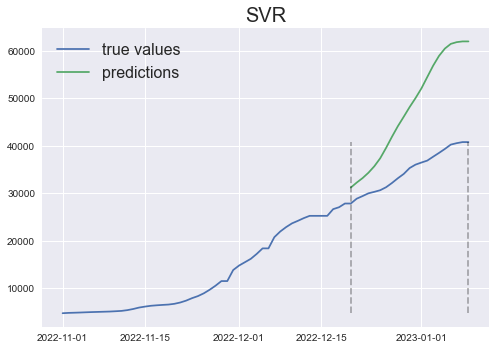

In [6]:
model=SVR(kernel='poly')
svr=ML_predict(data.loc[:'2023-1-15','北京市'],model,5,1,0.3)
svr()

In [23]:
a=pd.DataFrame()
a['测试']={'a':1,'b':2}

In [31]:
data.index[0].to_pydatetime()

datetime.datetime(2022, 11, 1, 0, 0)